Random Projection vs PCA

Begin importing dataset and understanding number of classes/features

In [1]:
from sklearn.datasets import fetch_rcv1
from sklearn.model_selection import train_test_split

rcv1 = fetch_rcv1(shuffle=True, random_state=0)
print(f"Data shape: {rcv1.data.shape}")

X, Y = rcv1.data, rcv1.target      # X: (n_samples, n_features), Y: multilabel CSR
names = rcv1.target_names

Data shape: (804414, 47236)


Create Random Projection Set

Create GuassianRandomProjetion and TSNE variables for dimensionality reduction. Then loop through the dataset in batches to make this less expensive. 

In [2]:
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

n_samples = X.shape[0]
batch_size = 10000
proj_dim = 50
rng = np.random.default_rng(42)
transformer = SparseRandomProjection(n_components=proj_dim, random_state=0, dense_output=False)
transformer.fit(X[:min(1000, n_samples)])

,n_components,50
,density,'auto'
,eps,0.1
,dense_output,False
,compute_inverse_components,False
,random_state,0


Sample in batches to make processing more memory friendly 

In [5]:
import scipy.sparse as sp
Z_batches = []
Y_batches = []

for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    Z_batches.append(transformer.transform(X[start:end]))   # stays sparse
    Y_batches.append(Y[start:end])                          # keep native type

# ----- concatenate Z -----
Z = np.vstack([z.toarray().astype(np.float32, copy=False) for z in Z_batches])  # dense after RP

# ----- concatenate Y robustly -----
# 1) If labels are sparse one-hot
if sp.issparse(Y_batches[0]):
    Y_all = sp.vstack(Y_batches, format='csr')
# 2) If labels are dense 2D (one-hot)
elif isinstance(Y_batches[0], np.ndarray) and Y_batches[0].ndim == 2:
    Y_all = np.vstack(Y_batches)
# 3) If labels are 1D integers
else:
    Y_all = np.concatenate(Y_batches, axis=0)

# ----- get flat label vector matching Z rows -----
if sp.issparse(Y_all):
    # sparse one-hot -> argmax per row
    labels_all = np.asarray(Y_all.argmax(axis=1)).ravel()
elif isinstance(Y_all, np.ndarray) and Y_all.ndim == 2 and Y_all.shape[1] > 1:
    # dense one-hot
    labels_all = Y_all.argmax(axis=1)
else:
    # already 1D labels
    labels_all = np.asarray(Y_all).ravel()

# sanity check
assert Z.shape[0] == labels_all.shape[0], f"Row mismatch: Z={Z.shape[0]} vs labels={labels_all.shape[0]}"

# ----- 25% subsample for t-SNE -----
subset_size = max(1, int(0.25 * Z.shape[0]))
idx = rng.choice(Z.shape[0], size=subset_size, replace=False)
Z_small = Z[idx]
labels_small = labels_all[idx]

# ----- t-SNE
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
Z_2d = tsne.fit_transform(Z_small)

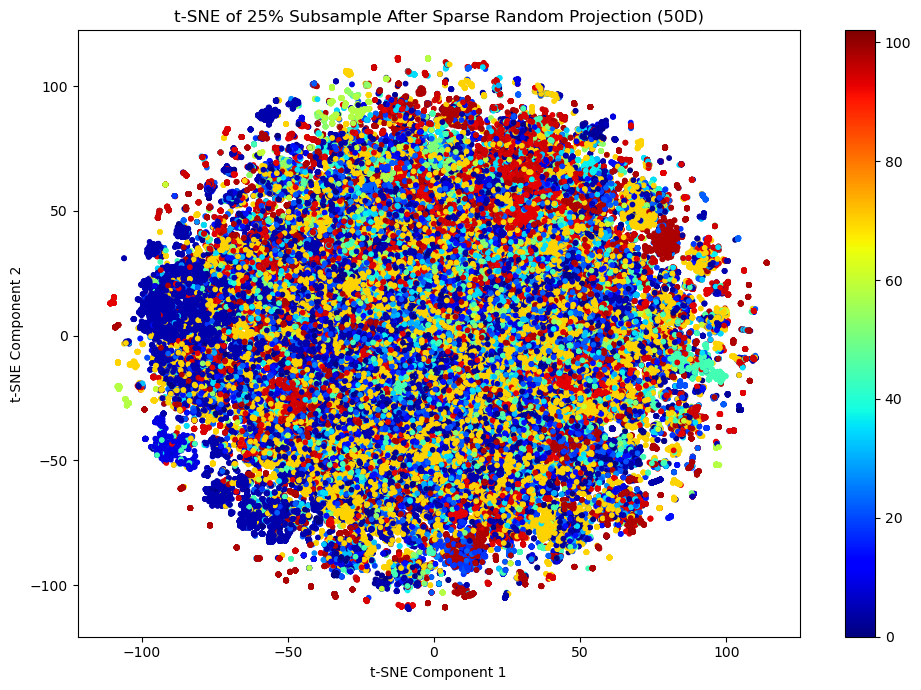

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels_small, cmap='jet', s=10)
plt.colorbar()
plt.title('t-SNE of 25% Subsample After Sparse Random Projection ({}D)'.format(proj_dim))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

This next block of code will potentially cause the code to crash if you run it on the entire dataset (Not recommended to run)

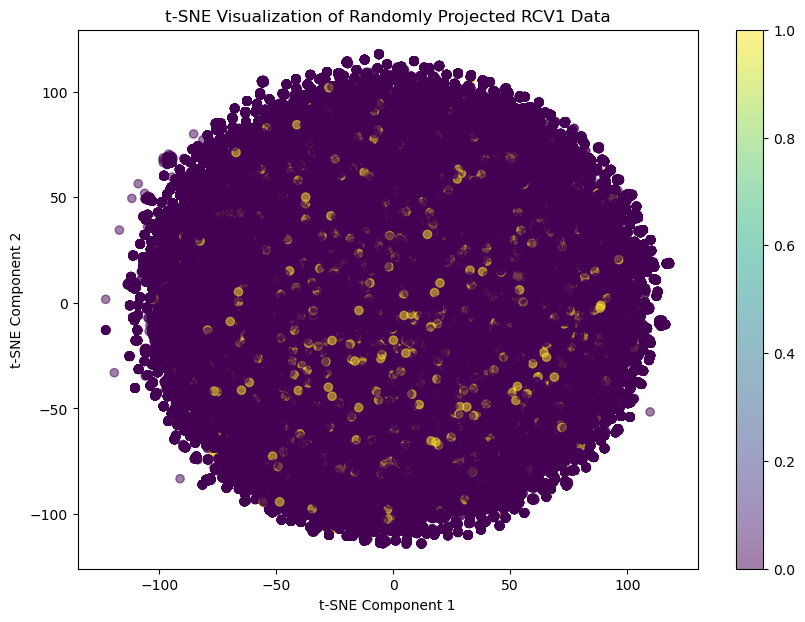

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= Y, cmap='jet', s=10)
plt.colorbar()
plt.title('t-SNE Visualization of Randomly Projected RCV1 Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Compare with PCA

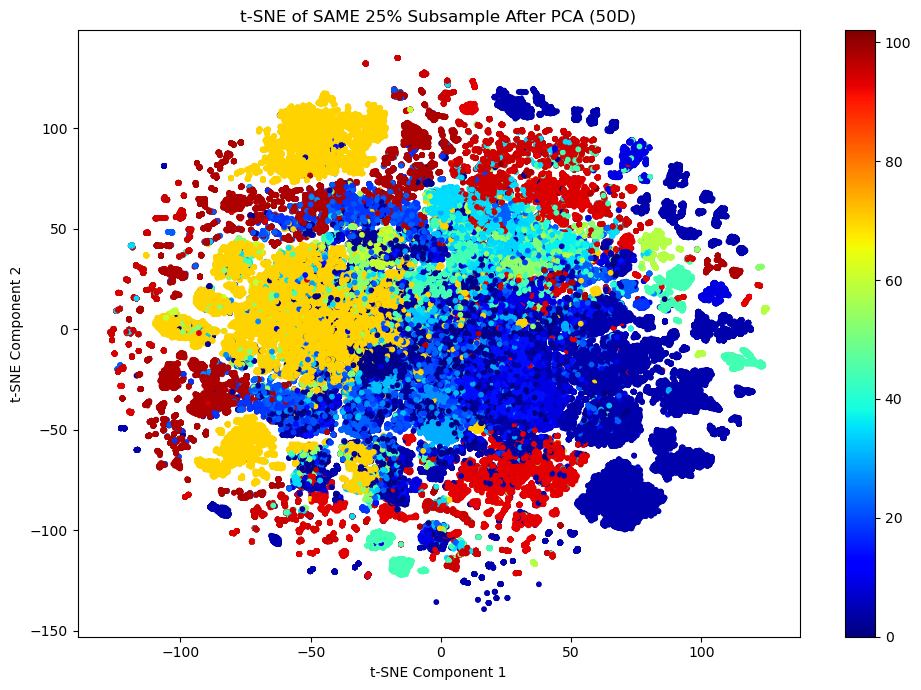

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import sparse as sp

# --- Assumes X (sparse), Y (1D or one-hot), and possibly idx already exist ---

n_samples = X.shape[0]
rng = np.random.default_rng(42)

# Reuse the same subset if idx exists; otherwise recreate deterministically (25%)
if "idx" in globals() and isinstance(idx, np.ndarray) and idx.ndim == 1:
    pass  # keep existing idx
else:
    subset_size = max(1, int(0.25 * n_samples))
    idx = rng.choice(n_samples, size=subset_size, replace=False)

# Slice the SAME chunk
X_sub = X[idx]                      # stays sparse here
# Build label vector for the subset
if sp.issparse(Y):
    labels_sub = np.asarray(Y[idx].argmax(axis=1)).ravel()
elif isinstance(Y, np.ndarray) and Y.ndim == 2 and Y.shape[1] > 1:
    labels_sub = Y[idx].argmax(axis=1)
else:
    labels_sub = np.asarray(Y)[idx].ravel()

# Densify only the subset (safe because it's just 25%)
X_sub_dense = X_sub.toarray().astype(np.float32, copy=False)

# --- PCA to 50D (use randomized solver for speed + reproducibility) ---
pca = PCA(n_components=50, svd_solver='randomized', random_state=0)
X_pca = pca.fit_transform(X_sub_dense)

# --- t-SNE to 2D for visualization ---
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_pca)

# --- Plot ---
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_sub, cmap='jet', s=10)
plt.colorbar()
plt.title("t-SNE of SAME 25% Subsample After PCA (50D)")
plt.xlabel("t-SNE Component 1"); plt.ylabel("t-SNE Component 2")
plt.tight_layout(); plt.show()